In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
print(cv2.__version__)
print(keras.__version__)
print(np.__version__)

3.4.1
2.2.4
1.16.3


In [4]:
model = keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

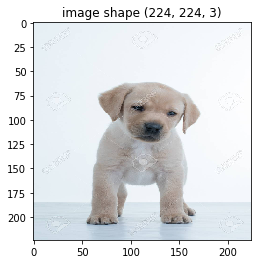

In [6]:
image = np.array(keras.preprocessing.image.load_img(path="./images/labrador.jpeg",target_size=(224,224)))
plt.title("image shape {}".format(image.shape))
plt.imshow(image)
plt.show()

In [7]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

In [8]:
preprocessed_image = keras.applications.vgg16.preprocess_input(image.astype(np.float32))
input_image = np.expand_dims(preprocessed_image, axis=0)  # Needs to be of shape (1, 224, 244, 3)
print(input_image.shape)

(1, 224, 224, 3)


In [9]:
predictions = np.squeeze(model.predict(input_image))
prediction_index = np.argmax(predictions)
prediction_class = labelmap[str(prediction_index)]
prediction_score = predictions[prediction_index]

print("Prediction: {}\nConfidence score: {}".format(prediction_class, prediction_score))

Prediction: Labrador_retriever
Confidence score: 0.8929281234741211


In [10]:
mask_size=50
masked_images = []
for i in range(0, image.shape[0], int(mask_size/2)):
    for j in range(0, image.shape[1], int(mask_size/2)):
        masked_image = image.copy()
        masked_image[i: i + mask_size, j: j + mask_size, :] = 0
        masked_images.append(masked_image)

In [11]:
len(masked_images)

81

In [12]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.
    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)
    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(math.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images


In [13]:
image_size = (int(np.sqrt(len(masked_images))), int(np.sqrt(len(masked_images))))
print(image_size)

(9, 9)


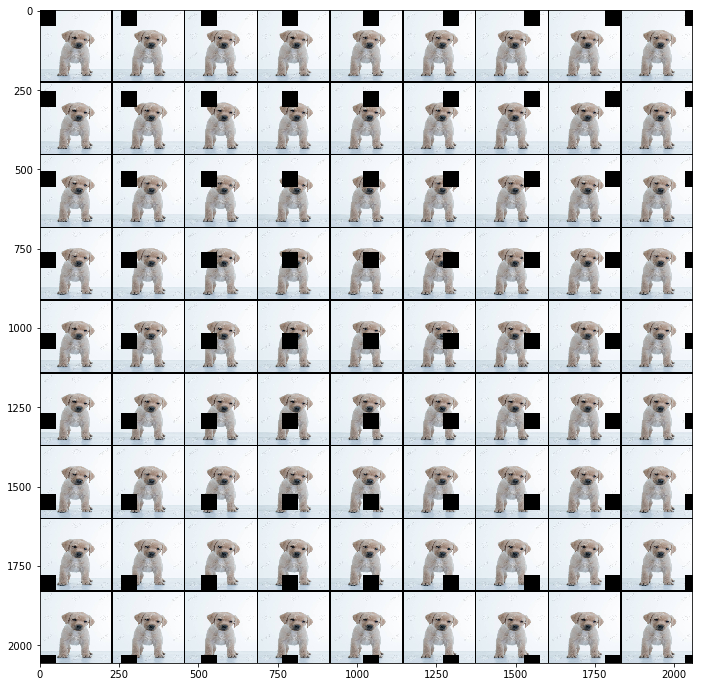

In [14]:
stitched_image = stitch_images(masked_images,cols=image_size[0])
plt.figure(figsize=(12,12))
plt.imshow(stitched_image)
plt.show()

In [15]:
def preprocess_image(img):
    img = keras.applications.vgg16.preprocess_input(img.astype(np.float32))
    return np.expand_dims(img, axis=0)

In [16]:
scores = []
for img in tqdm(masked_images):
    img = preprocess_image(img)
    predictions = np.squeeze(model.predict(img))
    scores.append(predictions[np.argmax(predictions)])

100%|██████████| 81/81 [00:20<00:00,  4.01it/s]


In [17]:
scores = np.array(scores).reshape(image_size)

In [18]:
np.set_printoptions(linewidth=200)  # for printing numpy array properly
print(scores)
print(scores.shape)

[[0.9112547  0.90719825 0.8987363  0.87498164 0.88173497 0.923456   0.9263144  0.9278905  0.91061884]
 [0.89993614 0.8756059  0.5219777  0.40377277 0.23097217 0.8167612  0.8323226  0.92310125 0.9030789 ]
 [0.8797682  0.73711586 0.4083733  0.13148017 0.16595286 0.5514187  0.73170584 0.8814878  0.9079468 ]
 [0.88246256 0.82506126 0.4146162  0.34763587 0.1976472  0.33827868 0.72088236 0.84785444 0.90188545]
 [0.8921872  0.8264689  0.7287139  0.76832277 0.5605426  0.69579434 0.77847826 0.9052645  0.8947789 ]
 [0.89168257 0.8196702  0.7843842  0.7326889  0.90305364 0.76733696 0.8923926  0.8907151  0.88877624]
 [0.8822081  0.71325725 0.70374936 0.6683781  0.78579175 0.8778873  0.89646214 0.87959015 0.8868475 ]
 [0.8826143  0.7914077  0.8256121  0.79958045 0.88933086 0.89050615 0.9137738  0.89607173 0.89716524]
 [0.89499736 0.7680663  0.821584   0.8362572  0.89476144 0.890183   0.88124055 0.88596445 0.89171696]]
(9, 9)


In [19]:
heatmap = cv2.resize(scores, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)  # OpenCV is in BGR

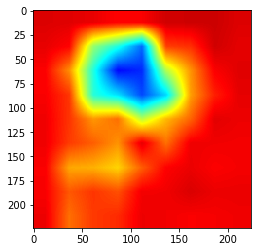

In [20]:
plt.imshow(heatmap)

In [21]:
def overlay(array1, array2, alpha=0.5):
    if alpha < 0. or alpha > 1.:
        raise ValueError("`alpha` needs to be between [0, 1]")
    if array1.shape != array2.shape:
        raise ValueError('`array1` and `array2` must have the same shapes')

    return (array1 * alpha + array2 * (1. - alpha)).astype(array1.dtype)

In [22]:
superimposed_img = overlay(heatmap, image)

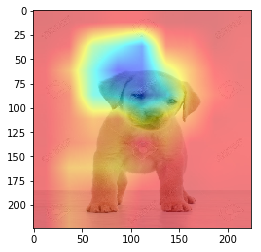

In [23]:
plt.imshow(superimposed_img)